In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
import textwrap
from PIL import Image
from transformers import AutoProcessor, Blip2Processor, Blip2ForConditionalGeneration
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from huggingface_hub import login
from ultralytics import YOLO


In [2]:
# Device setup
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'



In [ ]:
# Hugging Face login
login(token="")



In [4]:
# Load YOLOv8
yolo_model = YOLO("yolov8x.pt")



In [5]:
# Load BLIP-2 model for captioning
blip_processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
blip_model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl").to(DEVICE)



Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# Load Mistral-7B for reasoning
mistral_name = "mistralai/Mistral-7B-Instruct-v0.3"
tokenizer = AutoTokenizer.from_pretrained(mistral_name)
mistral_model = AutoModelForCausalLM.from_pretrained(
    mistral_name, torch_dtype=torch.float16, device_map="auto"
)
mistral_pipe = pipeline(
    "text-generation",
    model=mistral_model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    device_map="auto",
)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the disk.
Device set to use mps


In [7]:
# Function to extract frames
def extract_frames(video_path, interval=2):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_no = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        if frame_no % int(fps * interval) == 0:
            frames.append(frame)
    cap.release()
    return frames


In [8]:
# YOLO object detection
def detect_objects(frame):
    results = yolo_model(frame)[0]
    return [yolo_model.names[int(cls)] for cls in results.boxes.cls]


In [9]:
# BLIP-2 caption generation
def generate_caption(frame):
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    inputs = blip_processor(images=image, return_tensors="pt").to(DEVICE)
    ids = blip_model.generate(**inputs)
    return blip_processor.batch_decode(ids, skip_special_tokens=True)[0]


In [10]:
# Brightness estimation
def estimate_brightness(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)


In [11]:
# Hand detection with MediaPipe (max 2 hands + drawing)
def detect_hands(frame):
    mp_hands = mp.solutions.hands
    mp_draw = mp.solutions.drawing_utils
    annotated_frame = frame.copy()

    with mp_hands.Hands(static_image_mode=True, max_num_hands=2) as hands:
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb)
        
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(
                    image=annotated_frame,
                    landmark_list=hand_landmarks,
                    connections=mp_hands.HAND_CONNECTIONS
                )
            return 'Hands Detected', annotated_frame
        else:
            return 'No Hands', annotated_frame


In [12]:
# Posture detection with MediaPipe Pose
def detect_posture(frame):
    mp_pose = mp.solutions.pose
    with mp_pose.Pose(static_image_mode=True) as pose:
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if not results.pose_landmarks:
            return "Posture Undetected"

        landmarks = results.pose_landmarks.landmark
        shoulder_y = (landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y +
                      landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y) / 2
        hip_y = (landmarks[mp_pose.PoseLandmark.LEFT_HIP].y +
                 landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y) / 2
        knee_y = (landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y +
                  landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y) / 2

        delta_shoulder_hip = abs(shoulder_y - hip_y)
        delta_hip_knee = abs(hip_y - knee_y)

        if delta_shoulder_hip < 0.05 and delta_hip_knee < 0.05:
            return "Lying"
        elif delta_shoulder_hip < 0.15:
            return "Sitting"
        elif delta_shoulder_hip > 0.25:
            return "Standing"
        else:
            return "Fallen or Unusual"


In [13]:
from typing import Dict, Any

def reason_about_elderly_safety(context: Dict[str, Any]) -> str:
    """
    Uses a language model to assess the safety and channel availability of an elderly person
    based on visual and contextual input from a monitoring system.

    Returns a structured reasoning that includes:
    1. Safety Status: Safe / Risky / Unsafe
    2. Reasoning
    3. Suggested Action (if any)
    """
    prompt = f"""
You are a safety monitoring assistant for elderly care.

Analyze the following information and assess:
- Is the elderly person in a safe environment?
- Is there any risk based on posture, lighting, objects around, or hand activity?

Analyze the following scene and answer:
1. What **input channels** (e.g., hand, voice, gesture, eye/gaze) are likely available?
2. What **output channels** (e.g., speaking, typing, gesturing, eye movement) are likely available?

Scene Description: {context['caption']}
Detected Objects: {', '.join(context['objects'])}
Lighting Level (0–255): {context['brightness']}
Hand Status: {context['hand_state']}
Body Posture: {context['posture']}

Provide a judgment in this format:
1. Safety Status: Safe / Risky / Unsafe
2. Reasoning: ...
3. Suggested Action (if any): ...
"""

    output = mistral_pipe(prompt, max_new_tokens=256)[0]["generated_text"]
    response = output.split(prompt)[-1].strip()
    return response


In [14]:
# Main pipeline function
def run_elderly_monitoring(video_path):
    frames = extract_frames(video_path)
    print(f"\n📼 Total frames to process: {len(frames)}\n")

    for i, frame in enumerate(frames):
        print(f"🖼️ Frame {i + 1}/{len(frames)}")

        objects = detect_objects(frame)
        caption = generate_caption(frame)
        brightness = estimate_brightness(frame)
        hand_state, annotated_frame = detect_hands(frame)
        posture = detect_posture(frame)

        context = {
            "objects": objects,
            "caption": caption,
            "brightness": round(brightness, 2),
            "hand_state": hand_state,
            "posture": posture
        }

        reasoning = reason_about_elderly_safety(context)

        # Output summary
        print(f"🧠 Caption: {caption}")
        print(f"🎯 Objects: {objects}")
        print(f"💡 Brightness: {brightness:.2f}")
        print(f"🤚 Hand State: {hand_state}")
        print(f"🧍‍♂️ Posture: {posture}")
        print("📋 Reasoning:\n" + "\n".join(textwrap.wrap(reasoning, width=80)))

        # Show annotated frame
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Frame {i + 1} | Caption: {caption}", fontsize=10)
        plt.xlabel("\n".join(textwrap.wrap(reasoning, width=80)), fontsize=8, loc='left')
        plt.tight_layout()
        plt.show()

        print("\n" + "="*100 + "\n")


📼 Total frames to process: 3

🖼️ Frame 1/3

0: 640x384 1 person, 1 chair, 1 dining table, 392.1ms
Speed: 7.9ms preprocess, 392.1ms inference, 11.4ms postprocess per image at shape (1, 3, 640, 384)


I0000 00:00:1747172687.738721   15157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1747172687.762796   20461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747172687.770204   20459 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1747172687.791649   15157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
W0000 00:00:1747172687.848456   20469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747172687.863233   20469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback t

🧠 Caption: a man swinging on a swing in front of a fire pit
🎯 Objects: ['person', 'dining table', 'chair']
💡 Brightness: 107.36
🤚 Hand State: No Hands
🧍‍♂️ Posture: Sitting
📋 Reasoning:
1. Input Channels: Eye/gaze, posture 2. Output Channels: Speaking, eye movement
1. Safety Status: Risky 2. Reasoning: The elderly person is sitting on a swing,
which is not a safe seating option for elderly individuals due to the potential
for falls. Additionally, the fire pit nearby presents a fire hazard. 3.
Suggested Action: Alert caregiver to the potential risk and suggest moving the
elderly person to a safer location, away from the swing and fire pit.


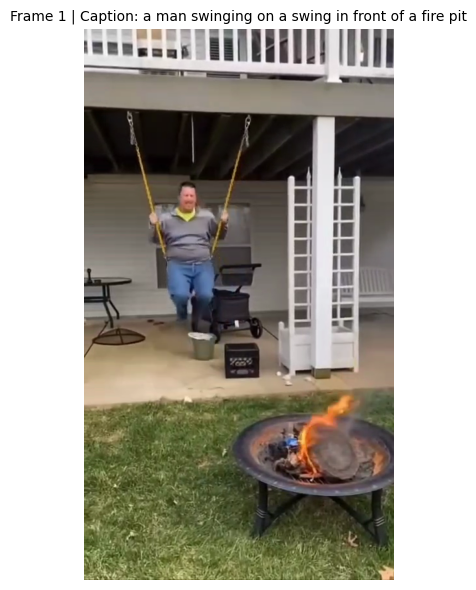



🖼️ Frame 2/3

0: 640x384 1 person, 1 dining table, 1138.7ms
Speed: 11.0ms preprocess, 1138.7ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 384)


I0000 00:00:1747174935.544719   15157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
W0000 00:00:1747174935.569216   61477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747174935.577038   61481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1747174935.612169   15157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
W0000 00:00:1747174935.672373   61484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747174935.688973   61491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Setting `pad_token_id` to `eos_token_id`:2 for o

🧠 Caption: a man swinging on a swing in front of a fire pit
🎯 Objects: ['person', 'dining table']
💡 Brightness: 109.25
🤚 Hand State: No Hands
🧍‍♂️ Posture: Sitting
📋 Reasoning:
1. Input Channels: Voice, Gesture (potentially, but not observed in this scene)
2. Output Channels: Speaking  1. Safety Status: Safe (for the moment) 2.
Reasoning: The elderly person is sitting on a swing, which is a safe seating
arrangement. However, the fire pit nearby could potentially pose a risk if left
unattended. The lighting level is moderate, which is generally safe for
visibility. The hand status is not observed, so it's unclear if the person is
holding anything that could be a risk. 3. Suggested Action: Monitor the
situation to ensure the fire pit is not left unattended and the elderly person
is not holding anything that could potentially be a risk. If the elderly person
starts to stand up or move towards the fire pit, intervene to ensure their
safety.


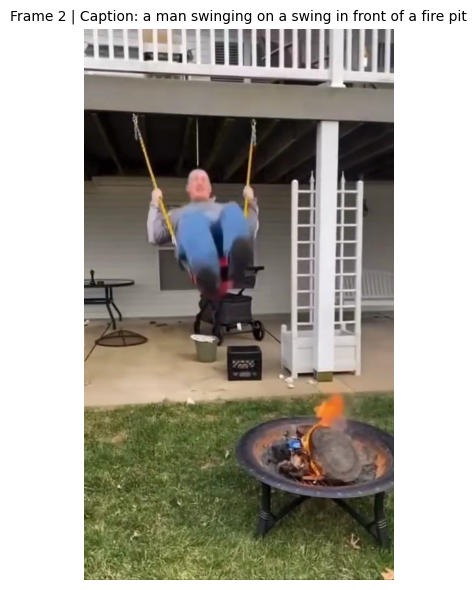



🖼️ Frame 3/3

0: 640x384 1 bird, 1 dining table, 1319.4ms
Speed: 15.7ms preprocess, 1319.4ms inference, 18.6ms postprocess per image at shape (1, 3, 640, 384)


I0000 00:00:1747178209.263733   15157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
W0000 00:00:1747178209.314538  128954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747178209.323631  128954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1747178209.343425   15157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
W0000 00:00:1747178209.402911  128962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747178209.417616  128965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Setting `pad_token_id` to `eos_token_id`:2 for o

🧠 Caption: a man is jumping over a fire pit
🎯 Objects: ['bird', 'dining table']
💡 Brightness: 107.54
🤚 Hand State: No Hands
🧍‍♂️ Posture: Posture Undetected
📋 Reasoning:
1. Input Channels: No input channels are available in this scene as the man is
jumping over a fire pit and there is no hand or body posture detected. 2. Output
Channels: No output channels are available as the man is jumping over a fire pit
and there is no hand or body posture detected.  1. Safety Status: Unsafe 2.
Reasoning: The man is jumping over a fire pit, which poses a significant risk of
injury due to the open flame. Additionally, the lighting level is relatively
low, which could make it difficult for the man to see and navigate safely. 3.
Suggested Action: Immediately alert emergency services and advise the man to
stop jumping over the fire pit and move to a safer location.


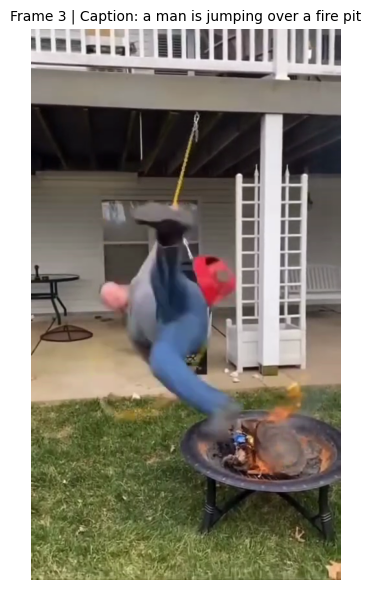

In [15]:
# Example usage
video_path = "/Users/samarjitboro/Desktop/MAJOR PROJECT/video/1111.mp4"  # Replace with your actual path
run_elderly_monitoring(video_path)